In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

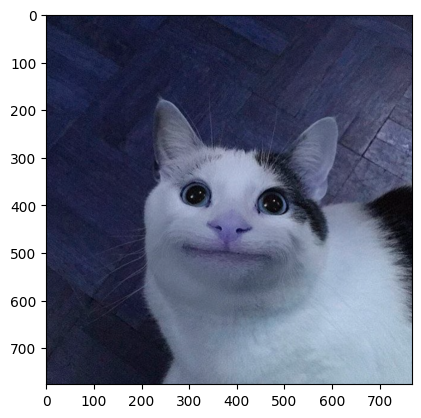

In [2]:
image = cv2.imread('./image.png')
plt.imshow(image);

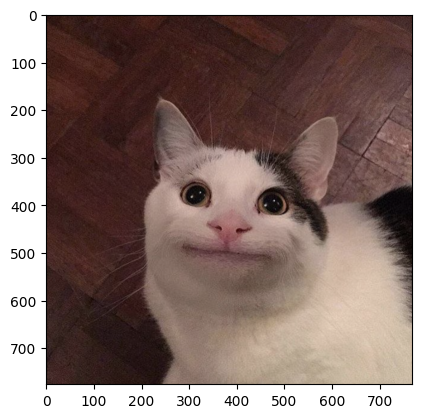

In [3]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

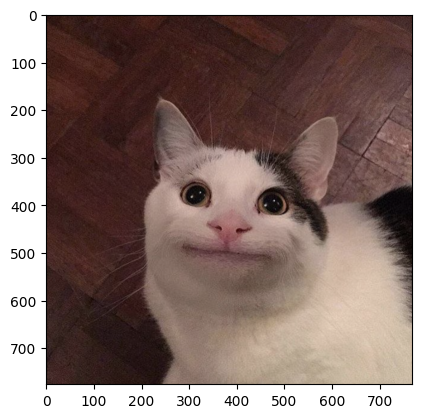

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

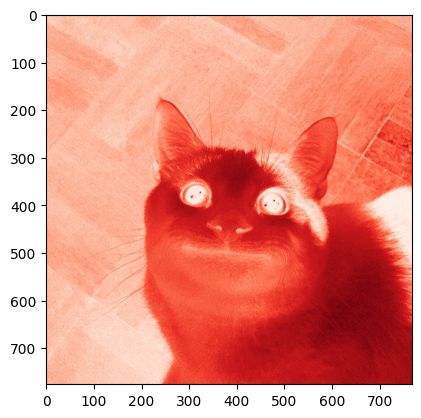

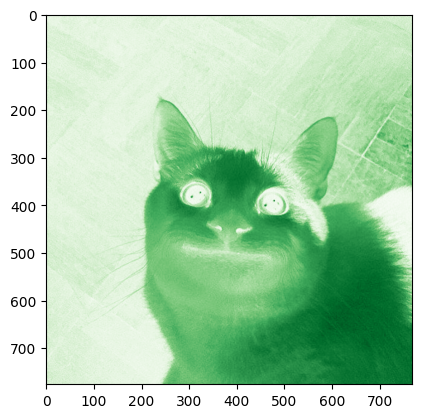

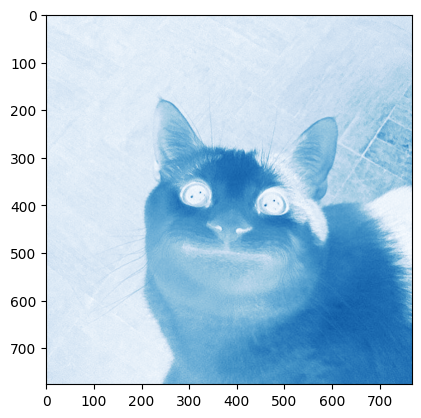

In [5]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


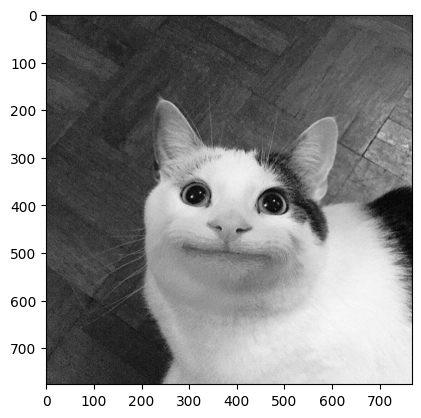

In [6]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [7]:
# !pip3 install scipy

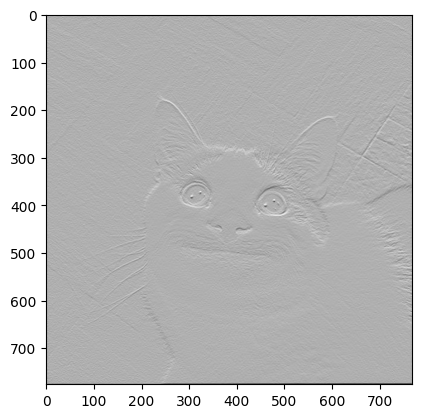

In [8]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

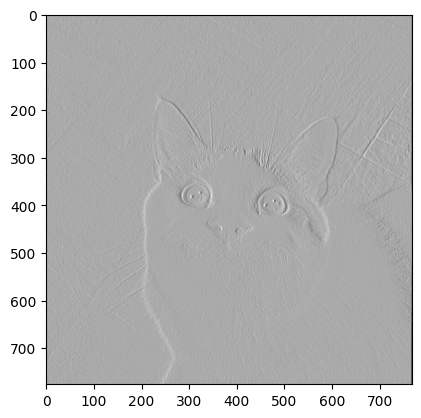

In [9]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

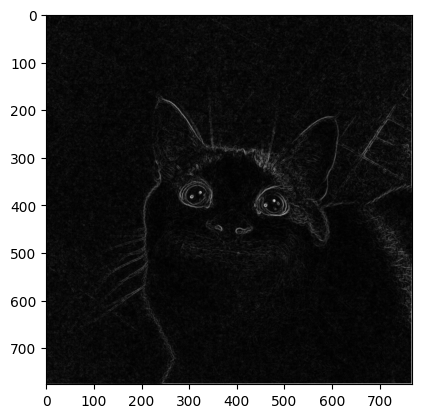

In [10]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [11]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [12]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [13]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [14]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [7]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [8]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [9]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [10]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

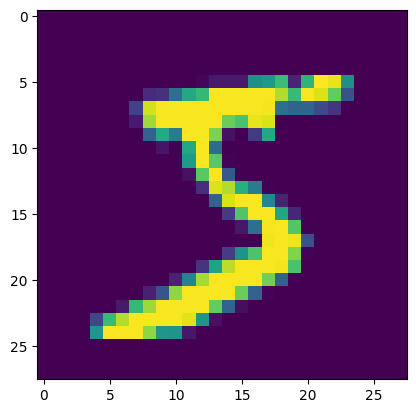

In [11]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [20]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [21]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [22]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 63.14it/s]


Epoch: 0, loss: 0.3203020393848419, accuracy: 0.9099


100%|██████████| 157/157 [00:02<00:00, 62.16it/s]


Epoch: 2, loss: 0.23288217186927795, accuracy: 0.9316


100%|██████████| 157/157 [00:02<00:00, 63.49it/s]

Epoch: 4, loss: 0.18695394694805145, accuracy: 0.9462


In [23]:
0.9462

0.9462

In [24]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [25]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 51.04it/s]


Epoch: 0, loss: 0.265990287065506, accuracy: 0.925


100%|██████████| 157/157 [00:04<00:00, 39.17it/s]


Epoch: 2, loss: 0.1271064132452011, accuracy: 0.9625


100%|██████████| 157/157 [00:03<00:00, 51.35it/s]

Epoch: 4, loss: 0.08593292534351349, accuracy: 0.9747


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [12]:
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn


def train2(net, optimizer, train_loader, val_loader,
           epochs, criterion, plot=True, verbose=True):
    train_loss_epochs, val_loss_epochs = [], []
    train_accuracy_epochs, val_accuracy_epochs = [], []

    n_params = 0
    for p in net.parameters():
        if p.requires_grad:
            n_params = n_params + p.numel()

    for epoch in tqdm(range(epochs)):
        losses = []
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

            loss.backward()
            optimizer.step()

        train_loss = np.mean(losses)
        train_acc = correct / len(train_loader.dataset)
        train_loss_epochs.append(train_loss)
        train_accuracy_epochs.append(train_acc)

        losses = []
        correct = 0
        for data, target in val_loader:
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

        val_loss = np.mean(losses)
        val_acc = correct / len(val_loader.dataset)
        val_loss_epochs.append(val_loss)
        val_accuracy_epochs.append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train: loss={train_loss:.4f} | acc={train_acc:.4f}")
            print(f"  Val  : loss={val_loss:.4f} | acc={val_acc:.4f}")
            print(f"  Trainable params: {n_params}")

        if plot:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(val_loss_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Loss')
            plt.legend(); plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(val_accuracy_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy')
            plt.legend(); plt.grid(True)
            plt.show()

In [13]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

In [14]:
class ConvClassifier_1(nn.Module):
    def __init__(self, image_size, kernel_size=3):
        super(ConvClassifier_1, self).__init__()
        pad = kernel_size // 2
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size, padding=pad),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear((image_size // 2) * (image_size // 2) * 16, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [15]:
model = ConvClassifier_1(image_size=28)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.5636 | acc=0.8642
  Val  : loss=0.2475 | acc=0.9294
  Trainable params: 32618


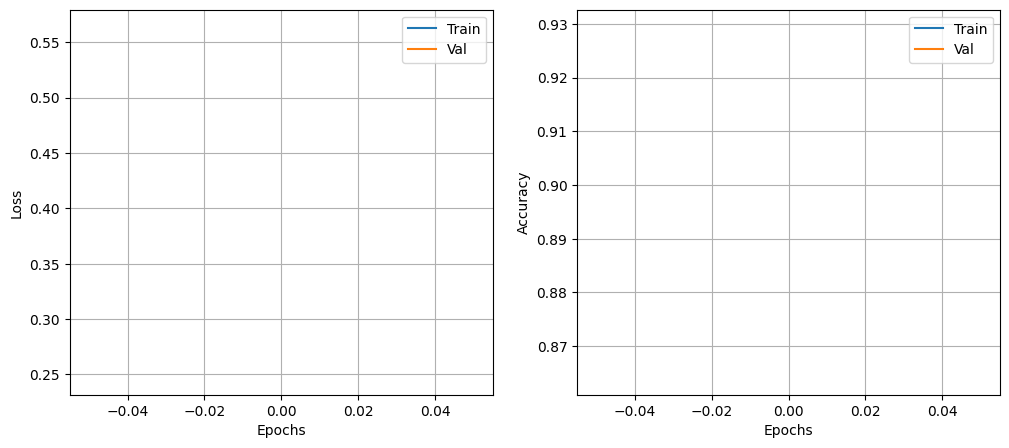

 10%|████████▎                                                                          | 1/10 [00:19<02:54, 19.41s/it]

Epoch 2/10
  Train: loss=0.2157 | acc=0.9369
  Val  : loss=0.1688 | acc=0.9503
  Trainable params: 32618


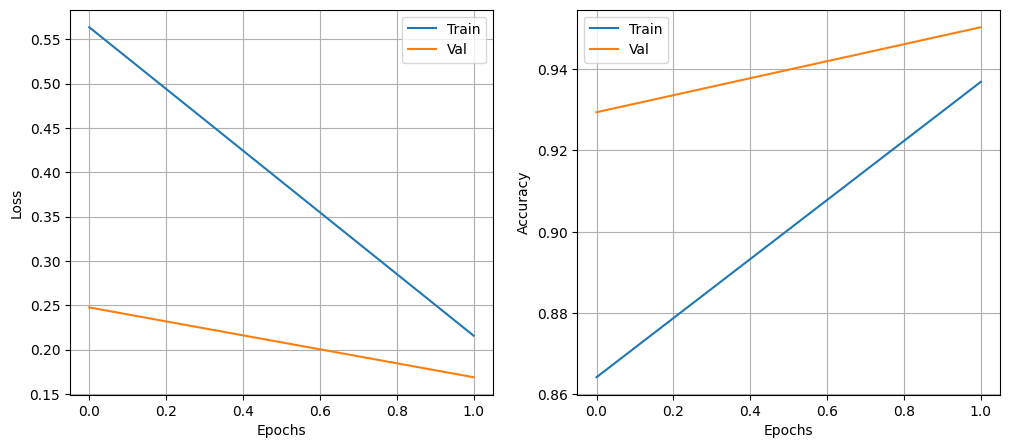

 20%|████████████████▌                                                                  | 2/10 [00:37<02:30, 18.82s/it]

Epoch 3/10
  Train: loss=0.1528 | acc=0.9554
  Val  : loss=0.1223 | acc=0.9638
  Trainable params: 32618


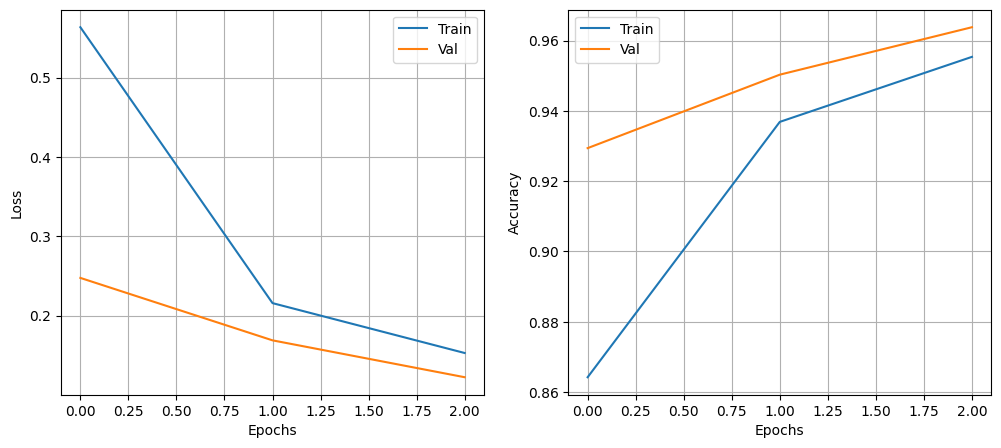

 30%|████████████████████████▉                                                          | 3/10 [00:56<02:09, 18.55s/it]

Epoch 4/10
  Train: loss=0.1167 | acc=0.9668
  Val  : loss=0.0967 | acc=0.9719
  Trainable params: 32618


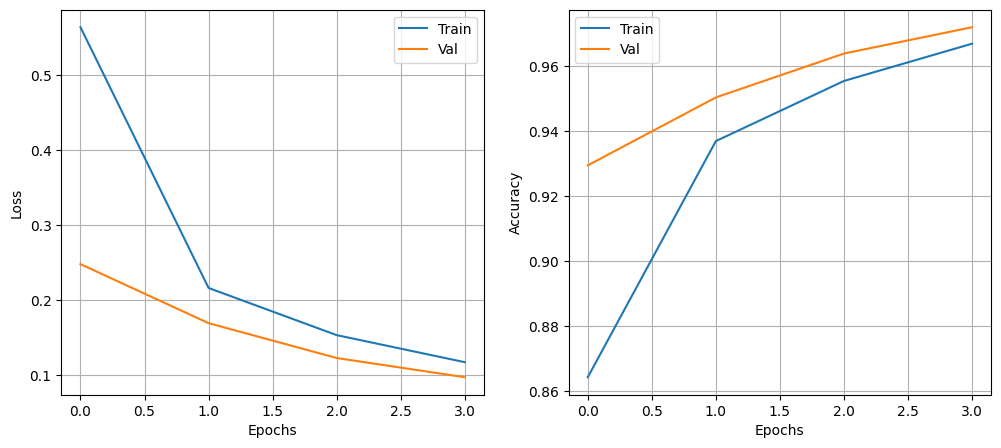

 40%|█████████████████████████████████▏                                                 | 4/10 [01:14<01:51, 18.55s/it]

Epoch 5/10
  Train: loss=0.0956 | acc=0.9726
  Val  : loss=0.0855 | acc=0.9748
  Trainable params: 32618


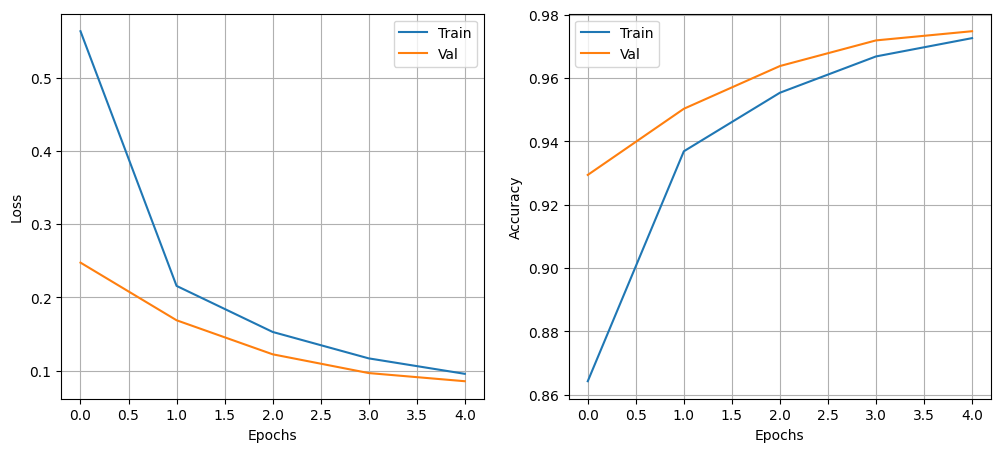

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:32<01:31, 18.25s/it]

Epoch 6/10
  Train: loss=0.0835 | acc=0.9761
  Val  : loss=0.0709 | acc=0.9780
  Trainable params: 32618


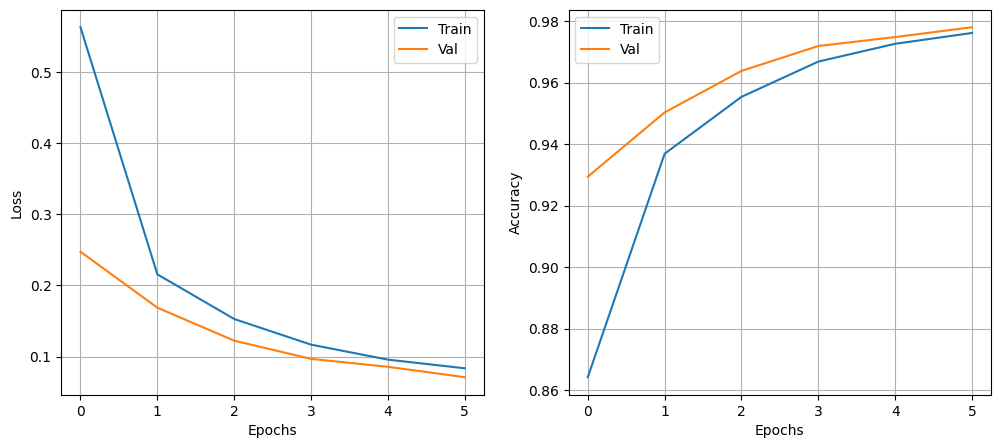

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:49<01:11, 17.99s/it]

Epoch 7/10
  Train: loss=0.0739 | acc=0.9786
  Val  : loss=0.0637 | acc=0.9791
  Trainable params: 32618


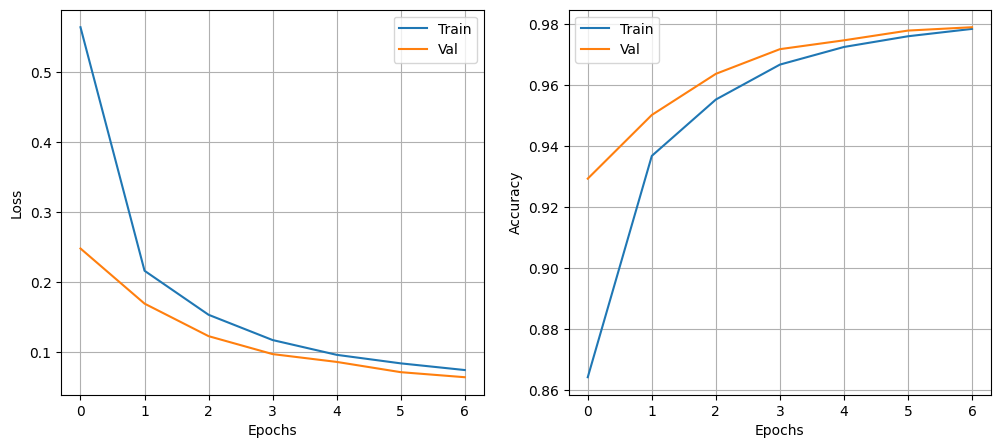

 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:07<00:53, 17.77s/it]

Epoch 8/10
  Train: loss=0.0675 | acc=0.9802
  Val  : loss=0.0611 | acc=0.9807
  Trainable params: 32618


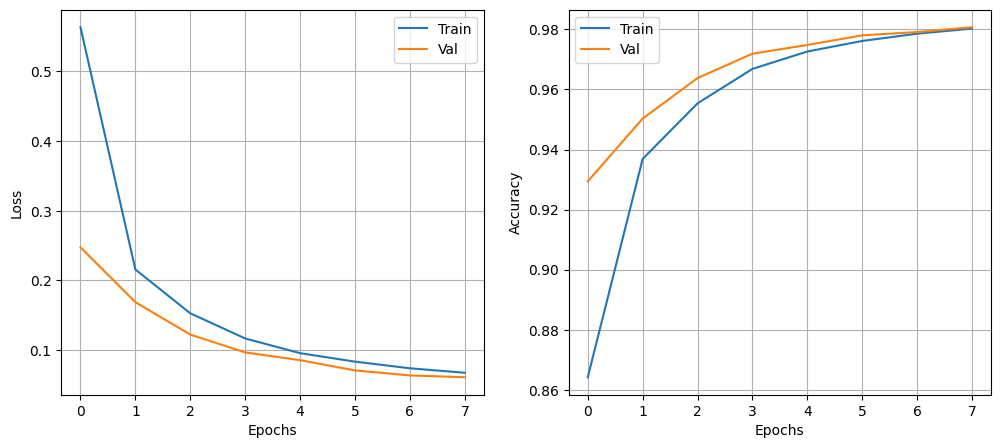

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:24<00:35, 17.77s/it]

Epoch 9/10
  Train: loss=0.0618 | acc=0.9819
  Val  : loss=0.0596 | acc=0.9812
  Trainable params: 32618


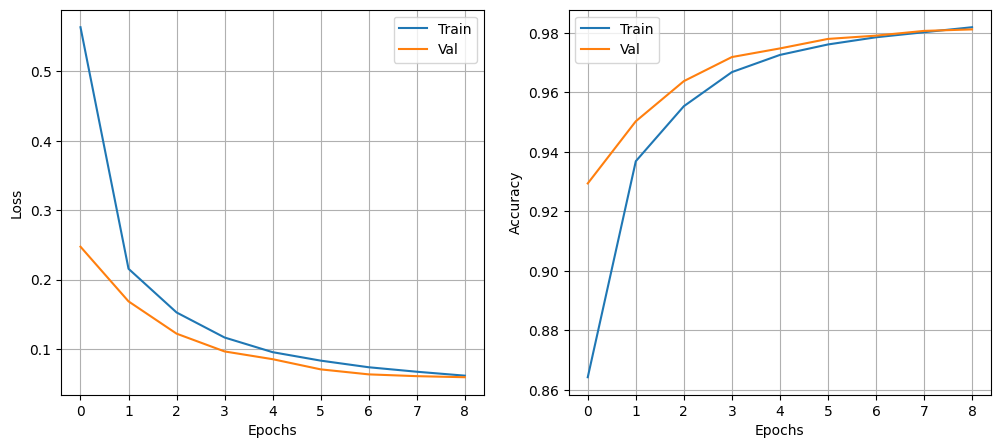

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:42<00:17, 17.70s/it]

Epoch 10/10
  Train: loss=0.0574 | acc=0.9832
  Val  : loss=0.0588 | acc=0.9806
  Trainable params: 32618


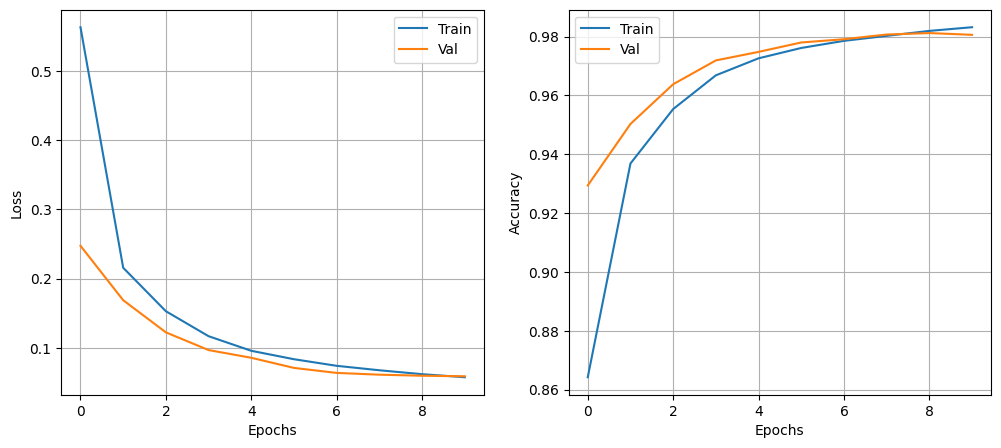

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.88s/it]


In [16]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_dataloader, val_loader=val_dataloader, plot=True, verbose=True)

In [17]:
# kernel_size = 5
class ConvClassifier_2(nn.Module):
    def __init__(self, image_size, kernel_size=5):
        super(ConvClassifier_2, self).__init__()
        pad = kernel_size // 2
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size, padding=pad),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear((image_size // 2) * (image_size // 2) * 16, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [18]:
model = ConvClassifier_2(image_size=28)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.4937 | acc=0.8740
  Val  : loss=0.2378 | acc=0.9296
  Trainable params: 34794


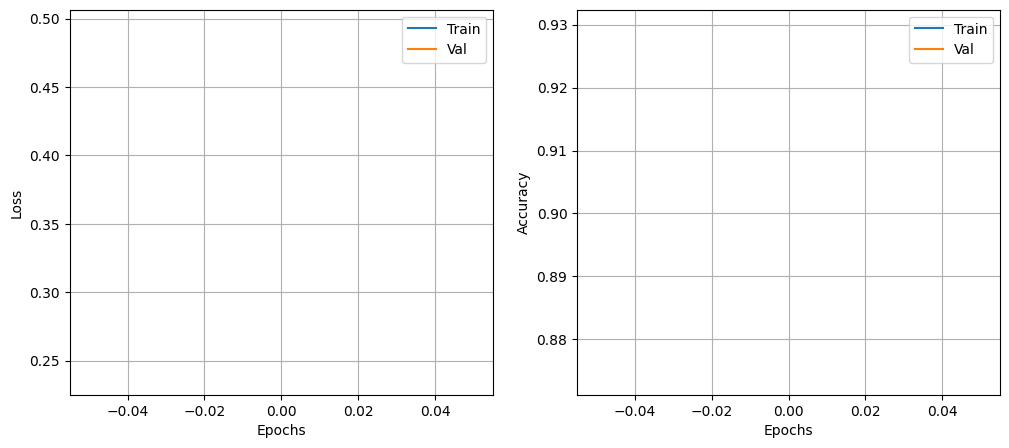

 10%|████████▎                                                                          | 1/10 [00:14<02:08, 14.23s/it]

Epoch 2/10
  Train: loss=0.1896 | acc=0.9453
  Val  : loss=0.1323 | acc=0.9615
  Trainable params: 34794


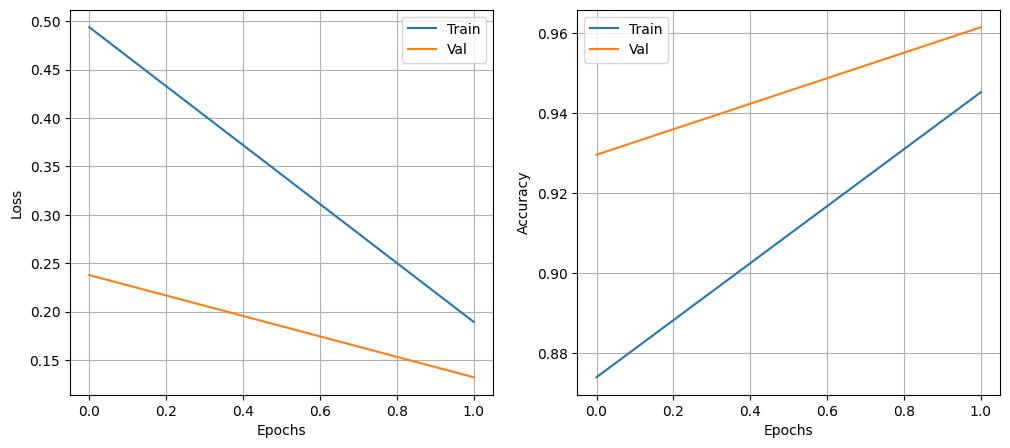

 20%|████████████████▌                                                                  | 2/10 [00:28<01:55, 14.38s/it]

Epoch 3/10
  Train: loss=0.1248 | acc=0.9644
  Val  : loss=0.1039 | acc=0.9683
  Trainable params: 34794


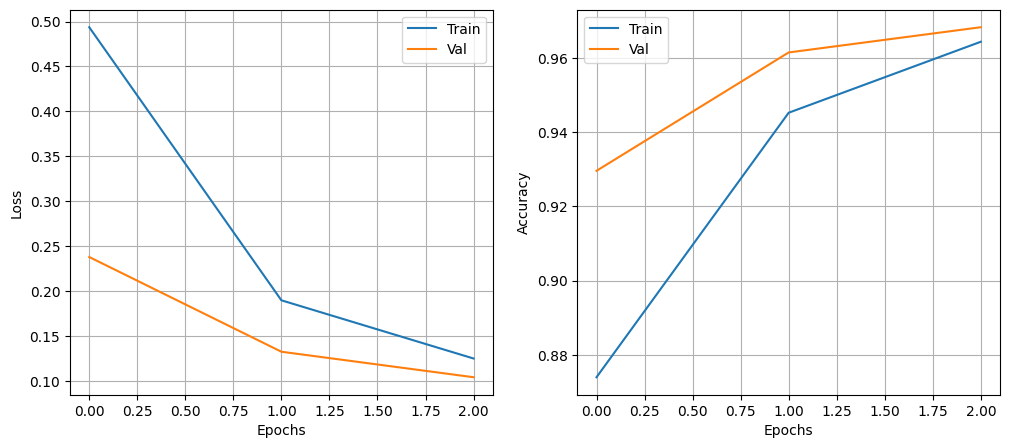

 30%|████████████████████████▉                                                          | 3/10 [00:43<01:42, 14.61s/it]

Epoch 4/10
  Train: loss=0.0954 | acc=0.9725
  Val  : loss=0.0732 | acc=0.9777
  Trainable params: 34794


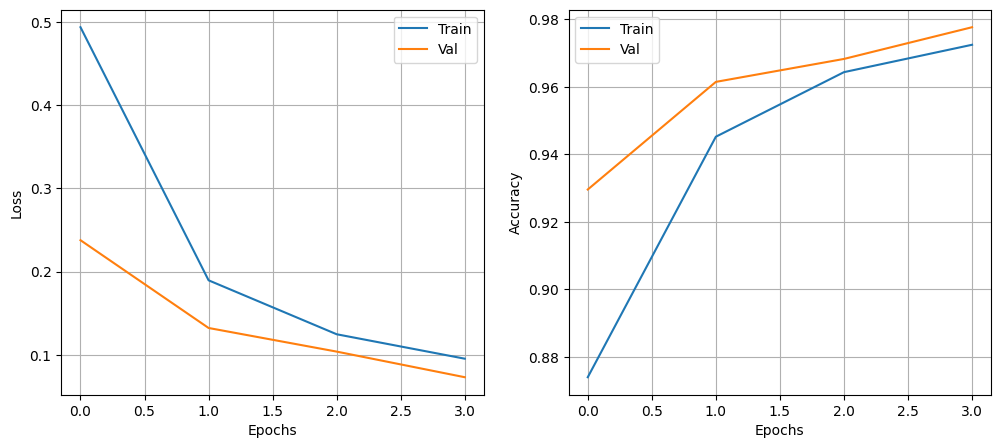

 40%|█████████████████████████████████▏                                                 | 4/10 [00:58<01:27, 14.53s/it]

Epoch 5/10
  Train: loss=0.0798 | acc=0.9771
  Val  : loss=0.0655 | acc=0.9791
  Trainable params: 34794


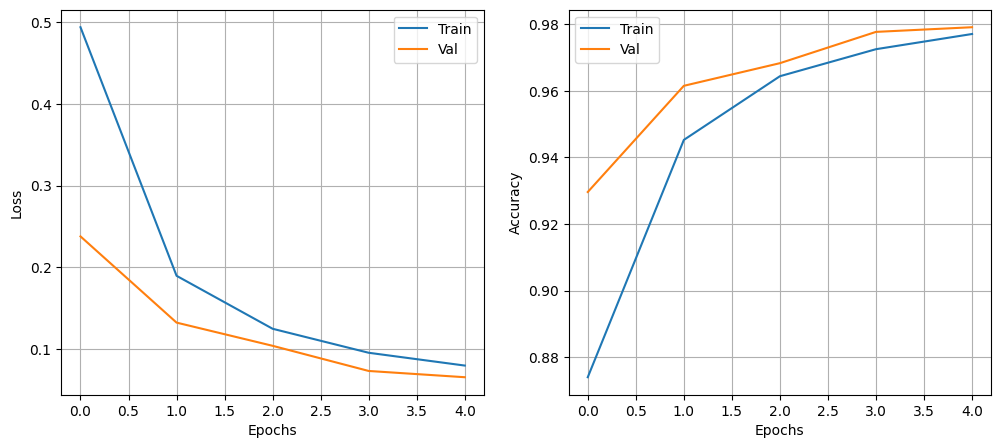

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:11<01:11, 14.24s/it]

Epoch 6/10
  Train: loss=0.0693 | acc=0.9797
  Val  : loss=0.0608 | acc=0.9815
  Trainable params: 34794


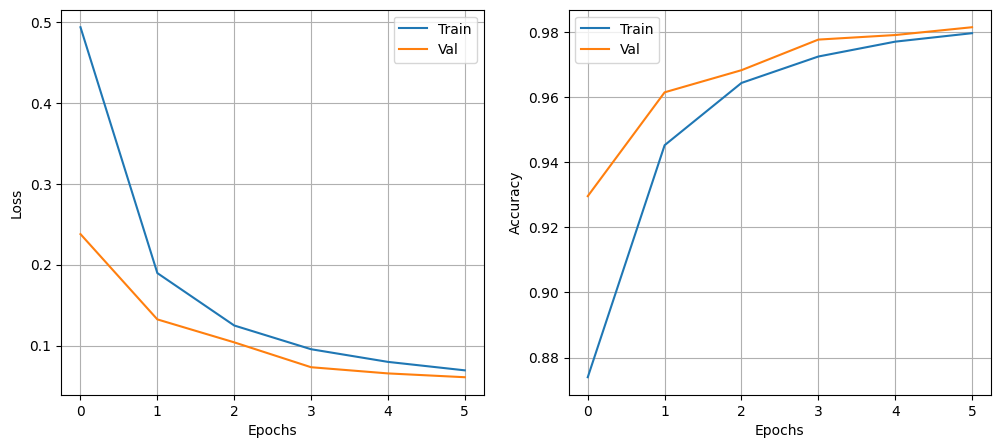

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:25<00:56, 14.08s/it]

Epoch 7/10
  Train: loss=0.0619 | acc=0.9813
  Val  : loss=0.0551 | acc=0.9815
  Trainable params: 34794


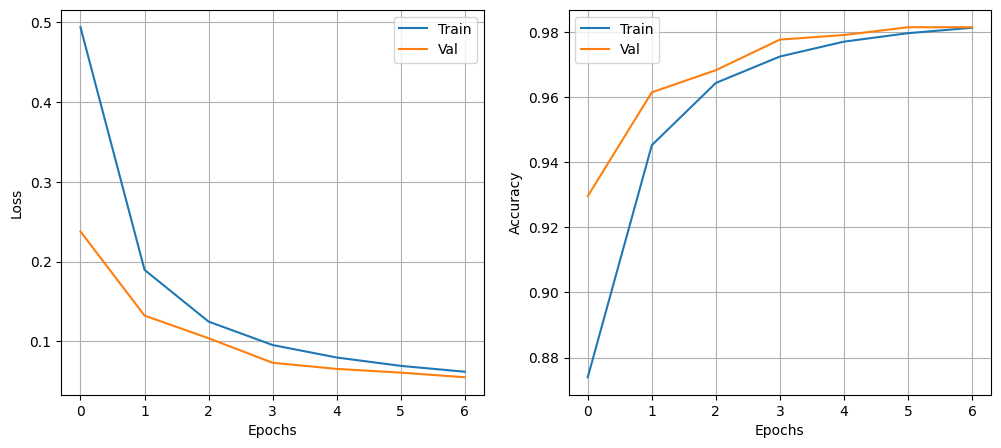

 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:39<00:42, 14.01s/it]

Epoch 8/10
  Train: loss=0.0562 | acc=0.9832
  Val  : loss=0.0476 | acc=0.9841
  Trainable params: 34794


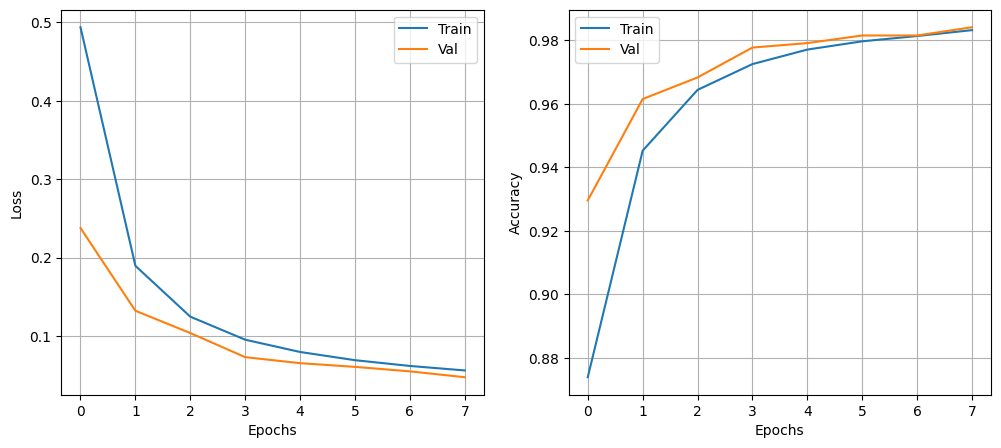

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:53<00:27, 13.92s/it]

Epoch 9/10
  Train: loss=0.0518 | acc=0.9843
  Val  : loss=0.0462 | acc=0.9840
  Trainable params: 34794


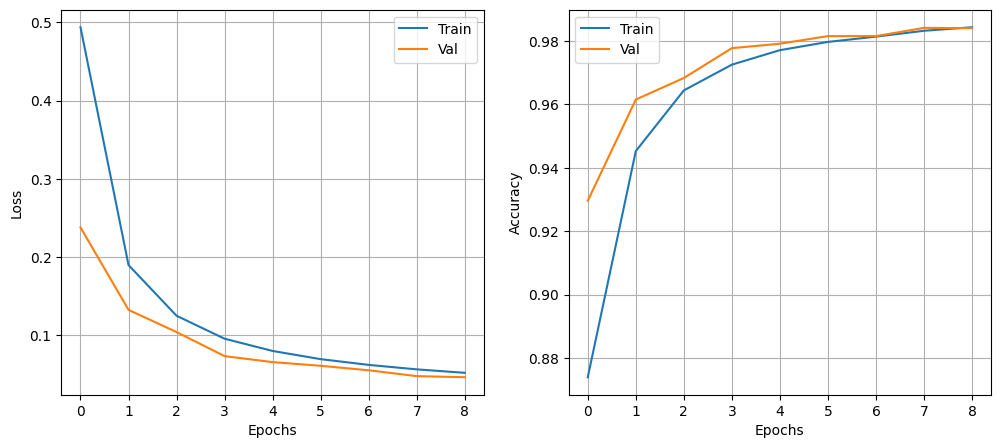

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:06<00:13, 13.85s/it]

Epoch 10/10
  Train: loss=0.0481 | acc=0.9858
  Val  : loss=0.0408 | acc=0.9850
  Trainable params: 34794


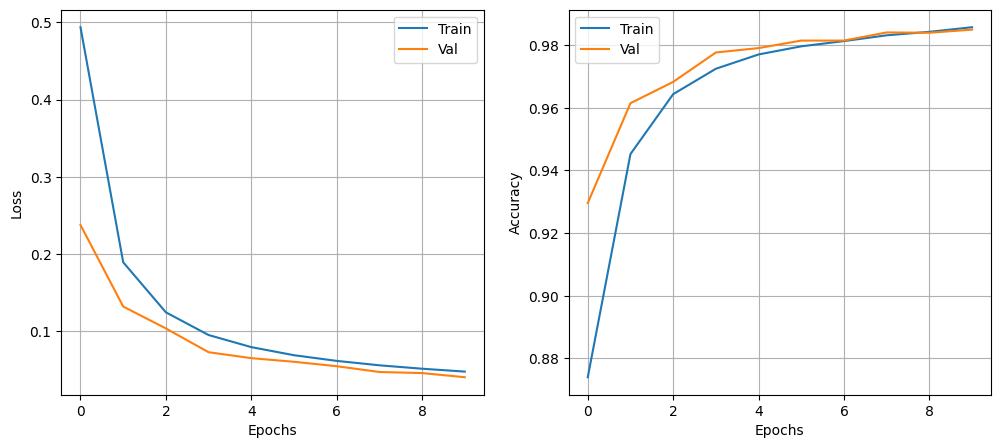

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:20<00:00, 14.05s/it]


In [19]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_dataloader, val_loader=val_dataloader, plot=True, verbose=True)

In [20]:
class ConvClassifier_3(nn.Module):
    def __init__(self, image_size, kernel_size=5):
        super(ConvClassifier_3, self).__init__()
        pad = kernel_size // 2
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size, padding=pad),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (image_size // 8) * (image_size // 8), 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [21]:
model = ConvClassifier_3(image_size=28)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.5494 | acc=0.8443
  Val  : loss=0.1995 | acc=0.9364
  Trainable params: 73290


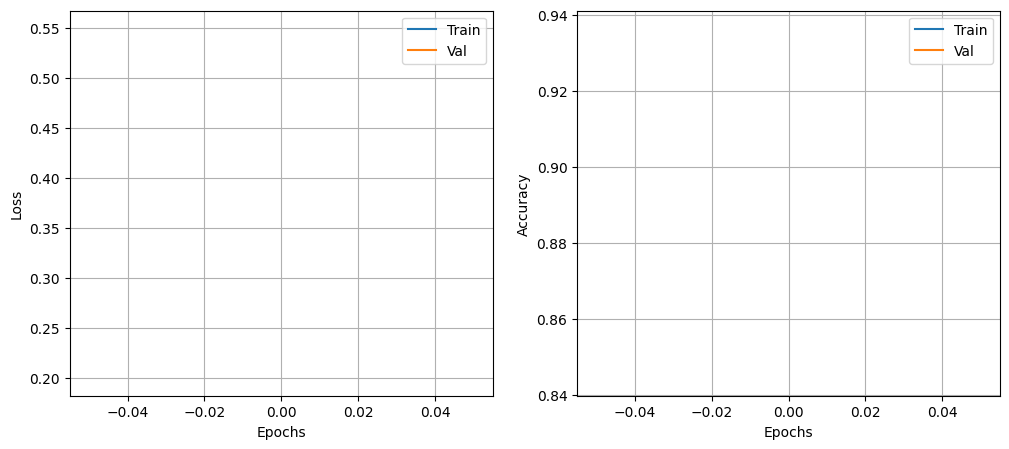

 10%|████████▎                                                                          | 1/10 [00:18<02:44, 18.23s/it]

Epoch 2/10
  Train: loss=0.1569 | acc=0.9517
  Val  : loss=0.1092 | acc=0.9661
  Trainable params: 73290


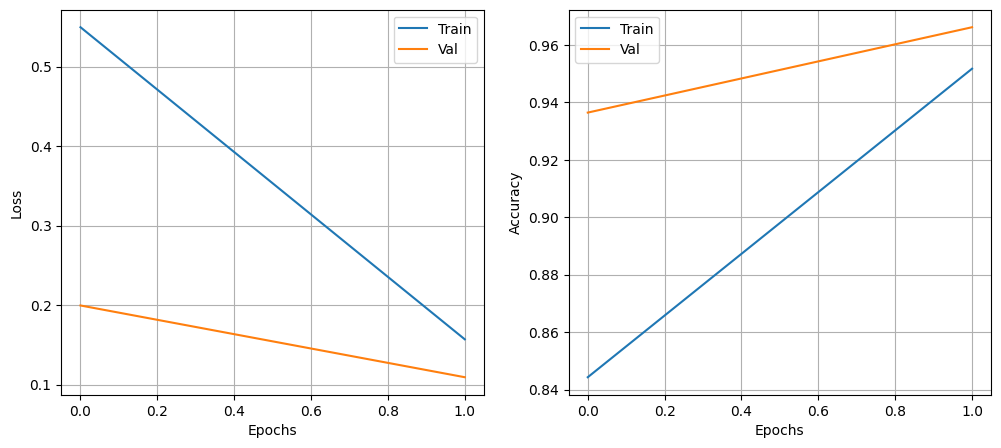

 20%|████████████████▌                                                                  | 2/10 [00:36<02:25, 18.13s/it]

Epoch 3/10
  Train: loss=0.1096 | acc=0.9664
  Val  : loss=0.0899 | acc=0.9710
  Trainable params: 73290


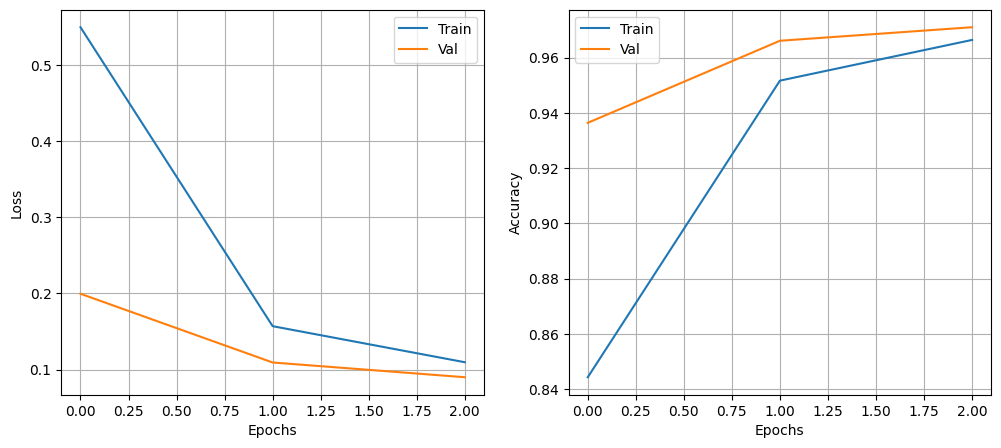

 30%|████████████████████████▉                                                          | 3/10 [00:54<02:06, 18.08s/it]

Epoch 4/10
  Train: loss=0.0850 | acc=0.9733
  Val  : loss=0.0812 | acc=0.9743
  Trainable params: 73290


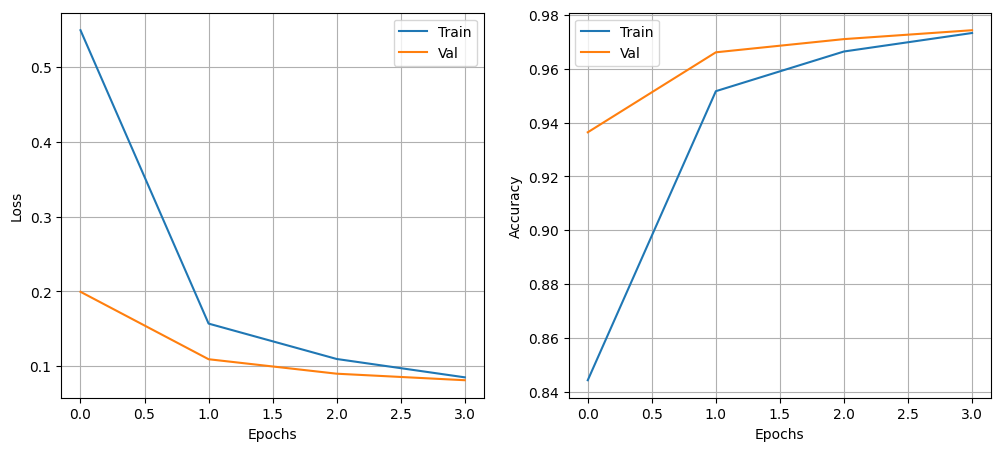

 40%|█████████████████████████████████▏                                                 | 4/10 [01:12<01:48, 18.03s/it]

Epoch 5/10
  Train: loss=0.0713 | acc=0.9776
  Val  : loss=0.0562 | acc=0.9811
  Trainable params: 73290


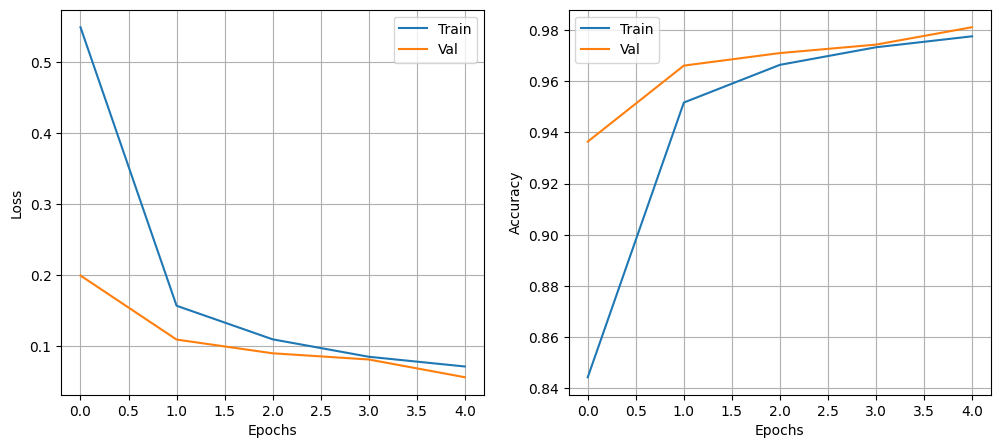

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:30<01:30, 18.12s/it]

Epoch 6/10
  Train: loss=0.0613 | acc=0.9803
  Val  : loss=0.0518 | acc=0.9823
  Trainable params: 73290


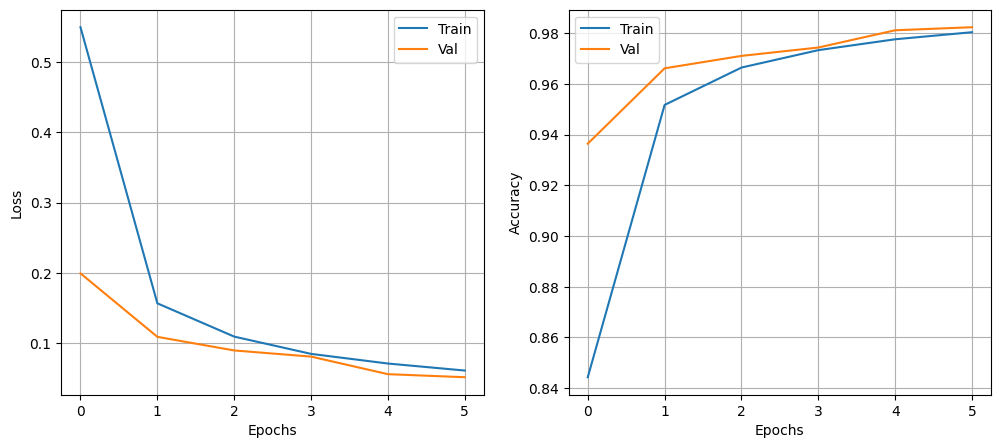

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:48<01:12, 18.18s/it]

Epoch 7/10
  Train: loss=0.0537 | acc=0.9832
  Val  : loss=0.0443 | acc=0.9857
  Trainable params: 73290


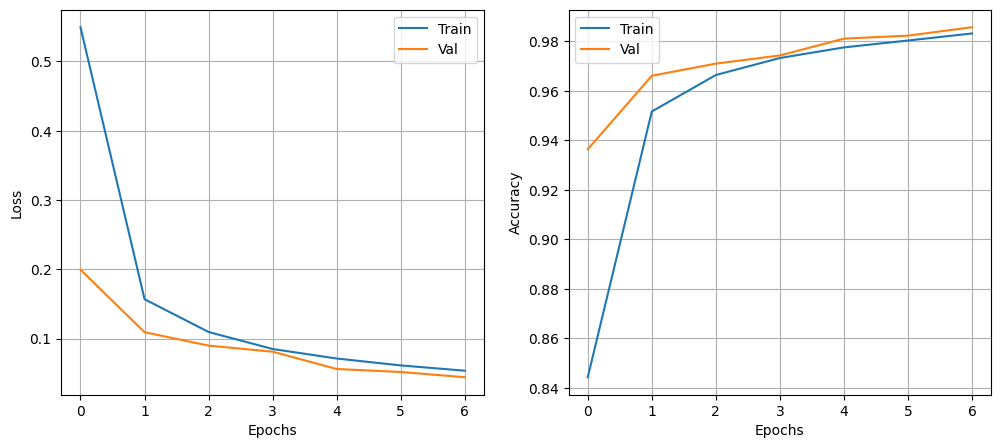

 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:06<00:54, 18.09s/it]

Epoch 8/10
  Train: loss=0.0481 | acc=0.9853
  Val  : loss=0.0404 | acc=0.9860
  Trainable params: 73290


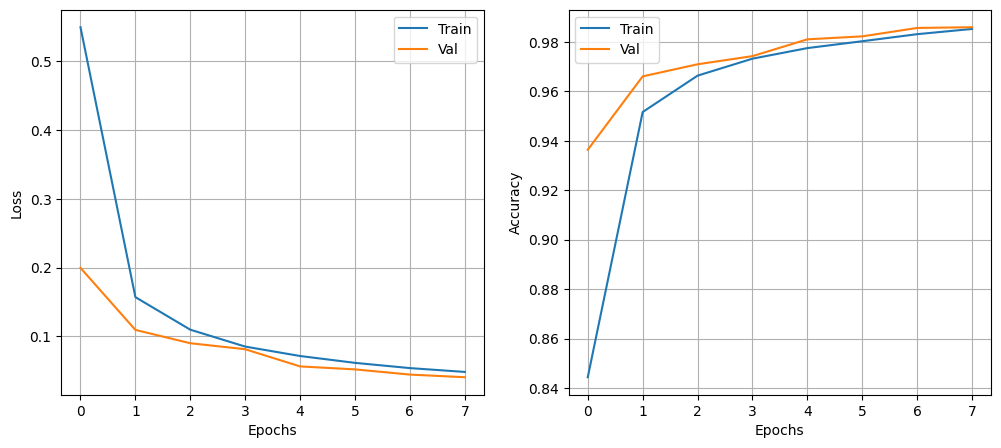

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:24<00:36, 18.09s/it]

Epoch 9/10
  Train: loss=0.0435 | acc=0.9868
  Val  : loss=0.0462 | acc=0.9853
  Trainable params: 73290


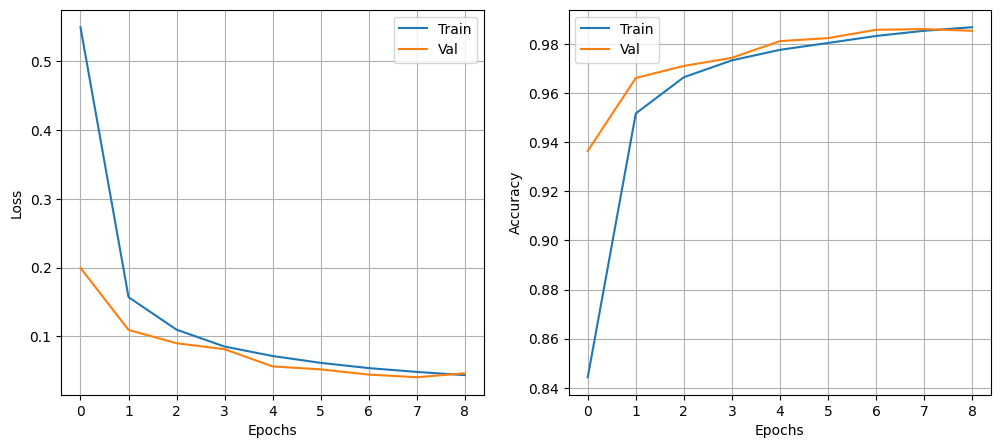

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:43<00:18, 18.24s/it]

Epoch 10/10
  Train: loss=0.0385 | acc=0.9878
  Val  : loss=0.0362 | acc=0.9877
  Trainable params: 73290


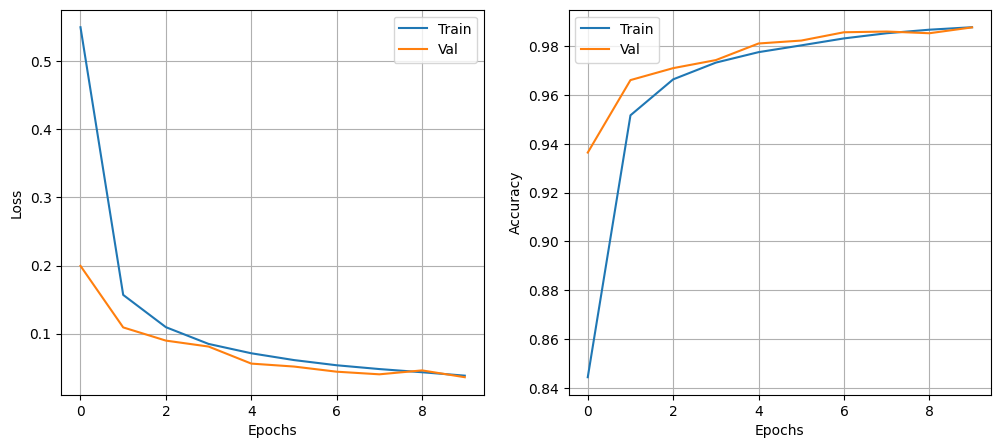

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.12s/it]


In [22]:
train2(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_dataloader, val_loader=val_dataloader, plot=True, verbose=True)